# [NML-25] Notebook 4: Graph Signal Processing

TAs: [Manuel Madeira](https://people.epfl.ch/manuel.madeira)

## Instructions

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Sometimes we provide variable names, such as `x = ...`; do not change names and stick to hinted typing, as they will be reused later.
Within the solution space, you can declare any other variable of function that you might need, but anything outside these lines shall not be changed, or it will invalidate your answers.

Theoretical questions shall be answered in the following markdown cell. The first line will be 
```markdown
**Your answer here:**
...
```

**Solutions:**
* Your code should be self-contained in the `.ipynb` file. The solution to the exercices will be provided in an external `.ipynb` file.

* Try to make your code clean and readable, it is a good training for the project. Provide meaningful variable names and comment where needed.

* You cannot import any other library than we imported, unless explicitly stated.

## Objective

This assignment features two sections: 
  - spectral graph filtering
  - label propagation

Please make sure you install the packages in `requirements.txt` respective to this notebook in your environment.

In [1]:
!pip install -r requirements.txt


In particular, we will need a package called [PyGSP](https://pygsp.readthedocs.io/en/stable/) that provides implementations of graph signal processing operations. For this assignment, you will be implementing the GSP operations we learned in class yourself, while we will give the PyGSP commands so you can double check the results.

In [2]:
import random
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pygsp

# Try different random seeds!
seed = 42
random.seed(seed)
np.random.seed(seed)

NB: You are encouraged to try different random seeds, remember to re-run the whole notebook after doing so.

## Section 1: Spectral filtering

This exercise covers basic notion of filtering in the graph Fourier domain. We start by retrieving two functions implemented in Notebook 2 that will reveal useful for this exercise.

In [3]:
def compute_laplacian(adjacency: np.ndarray, normalize: str):
    """normalize: can be None, 'sym' or 'rw' for the combinatorial, symmetric normalized or random walk Laplacians
    Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    diag = np.sum(adjacency, axis=1)

    n = len(diag)
    D = np.diag(diag)  # Degree matrix
    combinatorial = D - adjacency

    if normalize is None:
        return combinatorial

    diag[diag == 0] = 1e-12
    if normalize == "sym":
        diag_norm = 1 / np.sqrt(diag)
        D_norm = np.diag(diag_norm)

        return np.eye(n) - D_norm @ adjacency @ D_norm

    elif normalize == "rw":
        diag_norm = 1 / diag
        D_norm = np.diag(diag_norm)
        return np.eye(n) - D_norm @ adjacency

    else:
        raise ValueError(f"Unknown normalization: {normalize}")


def spectral_decomposition(laplacian: np.ndarray):
    """Return:
    l_eigvec (np.array): eigenvalues of the Laplacian
    l_eigvals (np.ndarray): corresponding eigenvectors.
    """
    if np.allclose(laplacian, laplacian.T):
        return np.linalg.eigh(laplacian)
    else:
        return np.linalg.eig(laplacian)

We will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.
We construct the normalized graph laplacians from the adjacency matrix and find its spectral decomposition.

In [4]:
from pygsp.graphs import Bunny
from mpl_toolkits.mplot3d import Axes3D # as Axes3d

/var/folders/xg/b9r_l6l15qgf304cdrs9z0zm0000gn/T/ipykernel_93649/3165208707.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',


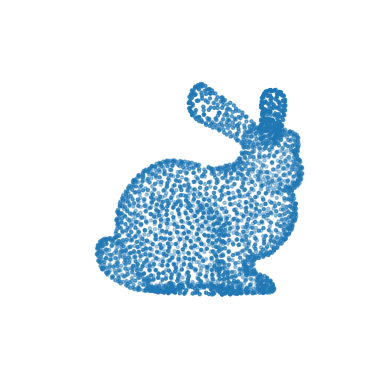

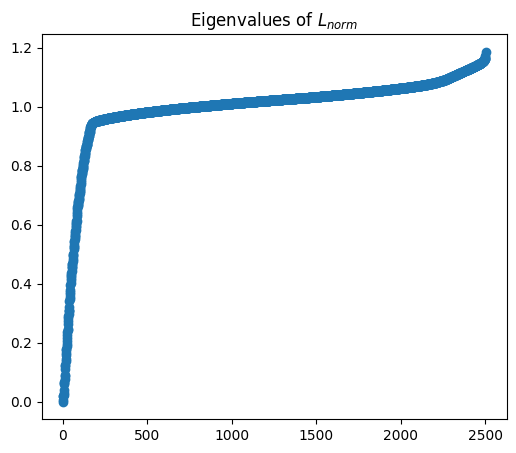

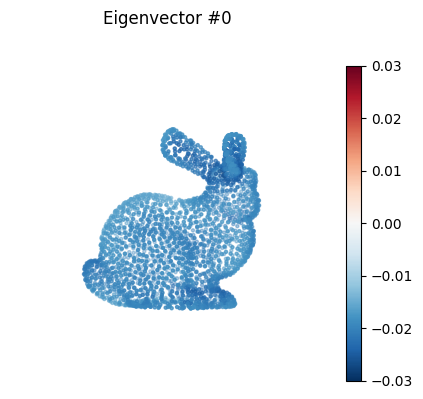

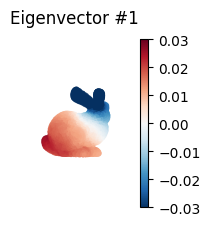

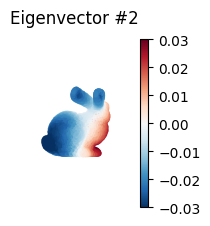

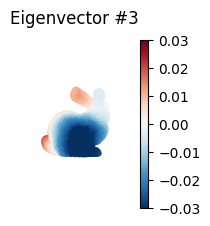

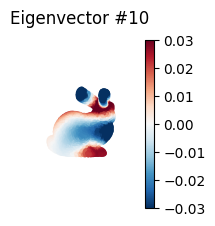

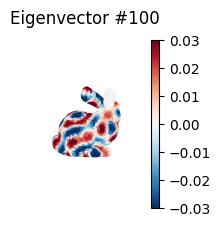

In [5]:
# Define the graph
G = Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]


def plot_bunny(x=None, title='', vlim=[-0.03, 0.03]):
    """ PLot a signal x on the bunny graph. """
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if x is not None:
        x = np.squeeze(x)
    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',
                   s=5, cmap='RdBu_r', vmin=vlim[0], vmax=vlim[1])
    ax.view_init(elev=-90, azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title, pad=30)
    if x is not None:
        fig.colorbar(p)
    plt.show()
        
        
plt.subplot(111, projection='3d')
plot_bunny()

# Compute the normalized Laplacian
laplacian = compute_laplacian(adjacency, normalize='sym')
laplacian = (laplacian + laplacian.T) / 2    # Make sure the matrix is symmetric despite numerical errors
lam, U = spectral_decomposition(laplacian)

# This lines should normally not be needed, but sometimes they eigenvalues are not sorted
argsort = np.argsort(lam)
lam = lam[argsort]
U = U[:, argsort]

# Eigenvalues plot
plt.figure(figsize=(6, 5))
plt.scatter(np.arange(len(lam)), lam)
plt.title('Eigenvalues of $L_{norm}$')
plt.show()


# Plot some eigenvectors of the graph
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(x=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(x=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(x=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(x=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(x=U[:,100], title='Eigenvector #100')

#### Question 1.1: How does the intuitive notion of "smoothness" relates to the eigenvalue corresponding to an eigenvector? How can the smoothness of a signal be measured?

**Your answer here:**

Signals become less and less smooth as the eigenvalue corresponding to an eigenvector increases. In general, the inverse of the smoothness of a signal on a graph can be measured by the quadratic form of the Laplacian: $x^{T}Lx = \sum_{i,j\in \varepsilon} w_{ij}\Vert x_i-x_j\Vert^2$. This quantity can also be seen as the square norm of the graph gradient.

#### Question 1.2: Implement the Graph Fourier Transform (GFT) of a graph signal and its inverse.

In [6]:
def GFT(signal: np.array, U: np.ndarray):
    """ signal: float array of size n.
        U: matrix of size n x n containing one eigenvector per column.
    """
    # Your solution here ###########################################################
    return U.T @ signal
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

def iGFT(fourier_coefficients: np.ndarray, U: np.ndarray):
    """ fourier_coefficients: float array of size n, containing a signal represented in the spectral domain
        U: matrix of size n x n containing one eigenvector per column.
    """
    # Your solution here ###########################################################
    return U @ fourier_coefficients
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### Filtering
We first define a signal `x`, and a noisy version of it `x_noisy`.

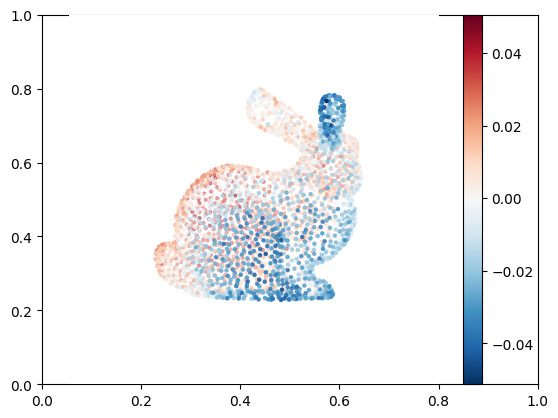

In [7]:
x = G.coords[:, 0] + G.coords[:, 1] + 3 * G.coords[:, 2]
x /= np.linalg.norm(x) 

noise = np.random.randn(n_nodes)
noise /= np.linalg.norm(noise) 

x_noisy = x + 0.3 * noise

plot_bunny(x_noisy, vlim=[min(x_noisy), max(x_noisy)])

We will try to extract the signal from the noise using graph filters. Let us start by creating 4 ideal graph filters: a low pass, a band pass, a high pass, and the filter that implements the solution of Tikhonov regularization.

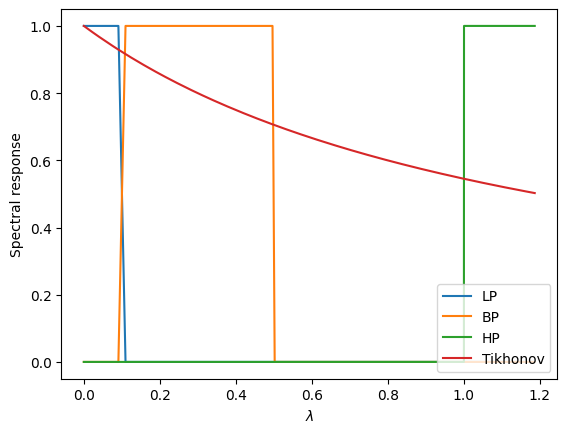

In [8]:
ideal_lp = np.ones((n_nodes,))
ideal_bp = np.ones((n_nodes,))
ideal_hp = np.ones((n_nodes,))

ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=1

alpha = 0.99 / np.max(lam)

ideal_tk = np.ones((n_nodes,))
ideal_tk = 1 / (1 + alpha*lam)

# Let's plot the spectral responses:

plt.plot(lam, ideal_lp, '-', label='LP')
plt.plot(lam, ideal_bp, '-', label='BP')
plt.plot(lam, ideal_hp, '-', label='HP')
plt.plot(lam, ideal_tk, '-', label='Tikhonov')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right')
plt.show()

#### Question 1.3: Implement the filtering function

In [9]:
def filter_signal(x: np.array, spectral_response: np.array, U: np.ndarray):
    """ Return a filtered signal
        The filter is defined in the spectral domain by its value on each eigenvector
        x (float array of size n): input signal
        spectral response (float array of size n): value of the filter at each eigenvalue
        U (n x n matrix): eigenvectors (one per column).
        returns:
        out (float array of size n): Filtered signal
    """
    # Your solution here ###########################################################
    x_gft = GFT(x, U)
    filter_gft = x_gft * spectral_response
    return iGFT(filter_gft, U)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

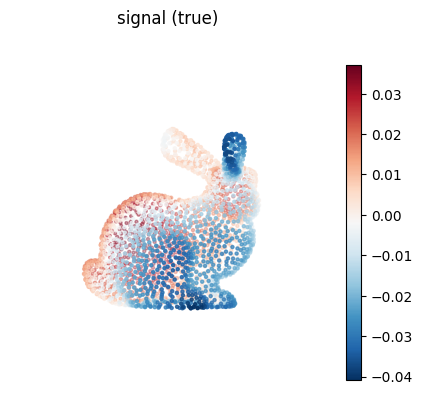

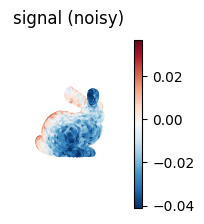

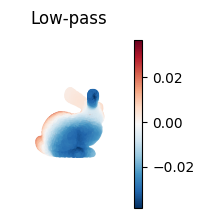

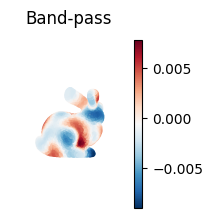

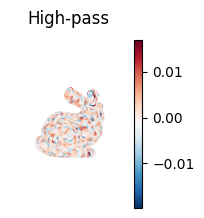

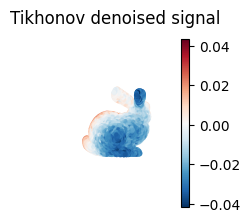

In [10]:
x_lp = filter_signal(x_noisy,ideal_lp, U)
x_bp = filter_signal(x_noisy,ideal_bp, U)
x_hp = filter_signal(x_noisy,ideal_hp, U)
x_tk = filter_signal(x_noisy,ideal_tk, U)

plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=x, title='signal (true)', vlim=[min(x), max(x)])
plt.subplot(232, projection='3d')
plot_bunny(x=x_noisy, title='signal (noisy)', vlim=[min(x), max(x)])
plt.subplot(233, projection='3d')
plot_bunny(x=x_lp, title='Low-pass', vlim=[min(x_lp), max(x_lp)])
plt.subplot(234, projection='3d')
plot_bunny(x=x_bp, title='Band-pass', vlim=[min(x_bp), max(x_bp)])
plt.subplot(235, projection='3d')
plot_bunny(x=x_hp, title='High-pass', vlim=[min(x_hp), max(x_hp)])
plt.subplot(236, projection='3d')
plot_bunny(x=x_tk, title='Tikhonov denoised signal', vlim=[min(x_tk), max(x_tk)])

This is how we can filter a graph signal with PyGSP directly. 

Try the following commands to test whether your implementation is accurate!

LP filtering correct: True
BP filtering correct: True
HP filtering correct: True
Tikhonov filtering correct: True


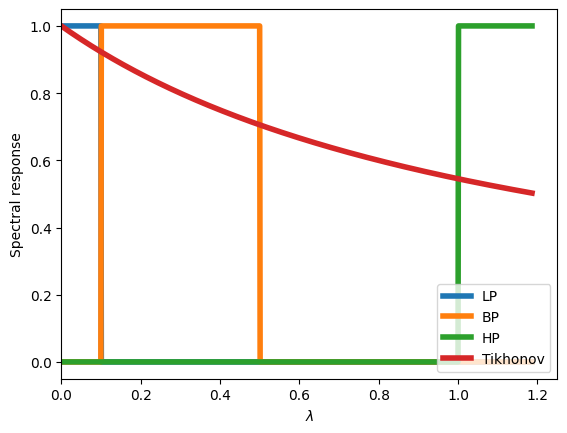

In [11]:
def get_filters_pygsp(G_pygsp: pygsp.graphs.Graph):
  G.compute_laplacian("normalized")
  G.L = (G.L + G.L.T) / 2 
  G.compute_fourier_basis()

  ideal_lp_pygsp = pygsp.filters.Filter(G_pygsp, 
                                        lambda x: (x < 0.1).astype(float))
  ideal_bp_pygsp = pygsp.filters.Filter(G_pygsp, 
                                        lambda x: ((0.1 <= x) 
                                        & (x <= 0.5)).astype(float))
  ideal_hp_pygsp = pygsp.filters.Filter(G_pygsp, 
                                        lambda x: (x > 1.0).astype(float))
  ideal_tk_pygsp = pygsp.filters.Filter(G_pygsp, 
                                        lambda x: 1 / (1 + alpha * x))

  return ideal_lp_pygsp, ideal_bp_pygsp, ideal_hp_pygsp, ideal_tk_pygsp

fig, ax = plt.subplots()
for filter_name, x, ideal_true in zip(["LP", "BP", "HP", "Tikhonov"], 
                                      [x_lp, x_bp, x_hp, x_tk], 
                                      get_filters_pygsp(G)):
  ideal_true.plot(plot_eigenvalues=False, ax=ax)
  x_true = ideal_true.filter(x_noisy)
  print(f"{filter_name} filtering correct: {np.allclose(x, x_true, atol=1e-2)}")
plt.xlim(0, 1.25)
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(labels=["LP", "BP", "HP", "Tikhonov"], loc='lower right')
plt.show()

#### Question 1.4: What kind of filter does Tikhonov regularization implement? Why?

**Your answer here:**

Tikhonov regularization corresponds to a (non-ideal) low-pass filter, which can be seen both on the bunny graph and in the spectral response of the filter, as its spectral response decays linearly with the frequency.

## Section 2: Label propagation

We will implement label propagation, which is an algorithm for semi-supervised learning: given a few labeled points, the goal is to assign labels to other points. We refer to [this paper](http://mlg.eng.cam.ac.uk/zoubin/papers/CMU-CALD-02-107.pdf) for the details about the algorithm.

In [12]:
import pygsp.graphs
import numpy as np
import numpy.linalg as LA
import numpy.random as npr
import matplotlib.pyplot as plt

We will use points sampled from the Swiss roll graph. Note that the (weighted) adjacency matrix **A** is already provided. 

#### Question 2.1: If it was not the case, how could you construct the adjacency matrix of the Swiss roll graph?

**Your answer here:**

We could build a similarity graph (using nearest neighbors or an epsilon-neighborhood).

We now proceed to the implementation of the label propagation algorithm.

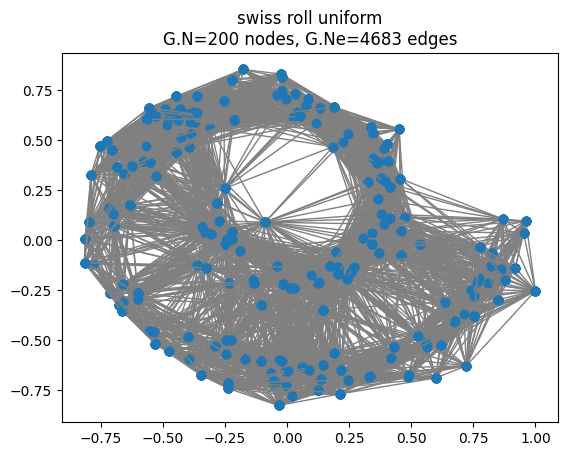

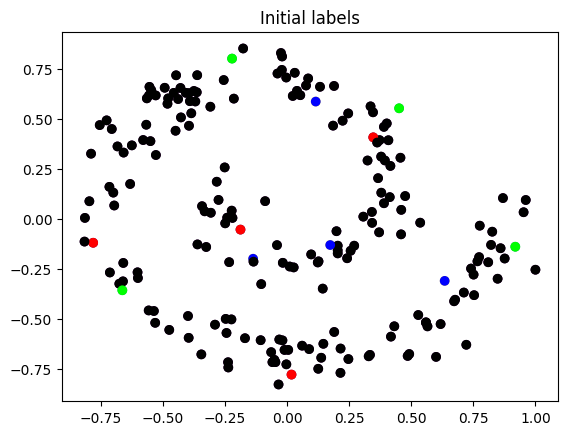

In [13]:
n = 200


def sample_signal(n, num_classes=3, num_labels_per_class=4, seed=0):
    npr.seed(seed)
    indices = npr.choice(n,
                         size= num_labels_per_class * num_classes,
                         replace=False)
    indices = indices.reshape(num_labels_per_class, num_classes)

    x = np.zeros((n, num_classes))
    for j in range(num_classes):
        x[indices[:, j], j] = 1
    return x

swiss_roll = pygsp.graphs.SwissRoll(n, dim=2, noise=0.05)
A = swiss_roll.W                    # weighted adjacency matrix
coords = swiss_roll.coords          # coordinates
x = sample_signal(n)

swiss_roll.plot()

plt.figure()
plt.scatter(coords[:, 0], coords[:, 1], c=np.argmax(x, axis=1))
plt.scatter(coords[:, 0], coords[:, 1], c=x)
plt.title("Initial labels")
plt.show()

#### Question 2.1: Go through the paper and implement the label propagation algorithm of section 2.2

In [14]:
class LabelPropagation():
    def __init__(self, num_iters, stopping_criterion=None):
        self.num_iters = num_iters
        self.stopping_criterion = stopping_criterion
    
    def __call__(self, A, x, coords, plot_each_iteration=True):
        """ A: n x n: weighted adjacency matrix
            x: n x d matrix containing the initial labels
            coords: n x 2 matrix containing the point coordinates.
            plot_each_iteration: bool.
            Return:
            pred: n x d prediction matrix (each row should sum to 1)
        """
        plt.figure()
        plt.scatter(coords[:, 0], coords[:, 1], c=x)
        plt.title(f"Initial state")
        plt.show()
        
        # Your solution here ###########################################################
        indices = np.argwhere(x == 1)             # the indices of the known labels
        num_labeled_nodes = indices.shape[0]
        
        A = A / np.sum(A, axis = 0)               # define probability transition matrix
        #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        for i in range(self.num_iters):
            # Your solution here ############################################################################
            # Propagate
            x = A @ x

            # Row Normalize
            normalizer = np.sum(x, axis=1)  # row normalize
            normalizer[normalizer == 0] = 1  # as we set the unlabeled nodes to 0s 
            x = x / normalizer
            
            # Clamp data labels
            for j in range(num_labeled_nodes):
                x[indices[j, 0], :] = 0
                x[indices[j, 0], indices[j, 1]] = 1 
            #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                
            if plot_each_iteration:
                plt.figure()
                plt.scatter(coords[:, 0], coords[:, 1], c=x)
                plt.title(f"After Iteration {i}")
                plt.show()
                
            if self.stopping_criterion is not None:
                if self.stopping_criterion.step(x):
                    print(f"Stopping criterion triggered after {i} iterations.")
                    break
        return x
    
    
def plot_predictions(x, coords):
    """ x: n x d matrix containing the predictions """
    predictions = np.argmax(x, axis=1)
    y = np.zeros(x.shape)
    for i in range(x.shape[0]):
        y[i, predictions[i]] = 1
    plt.figure()
    plt.scatter(coords[:, 0], coords[:, 1], c=y)
    plt.title("Final predictions")
    plt.show()

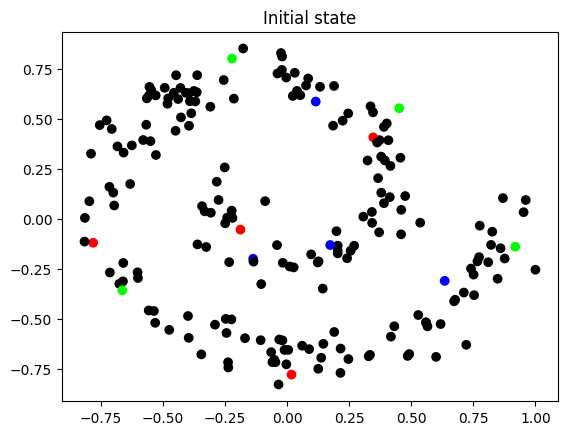

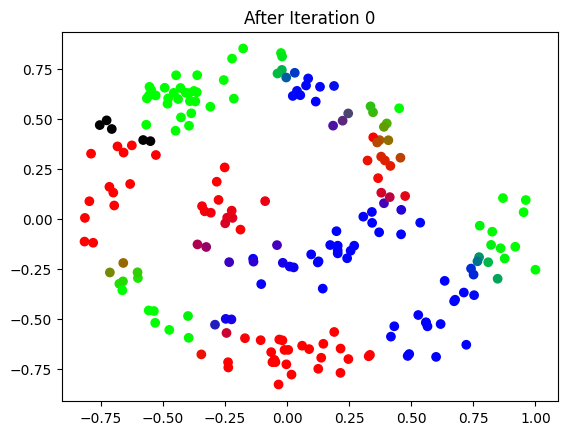

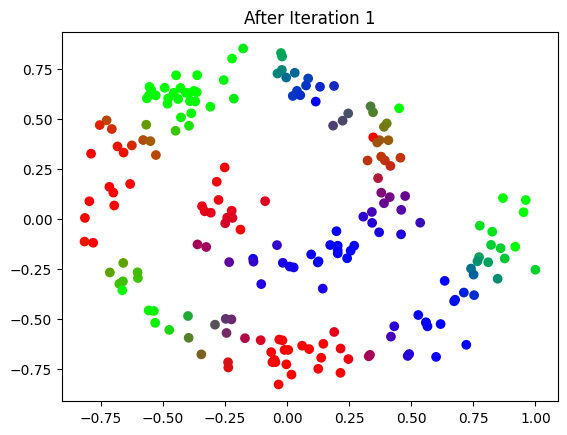

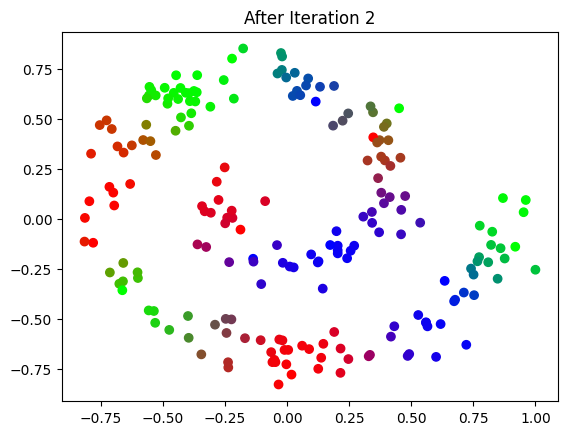

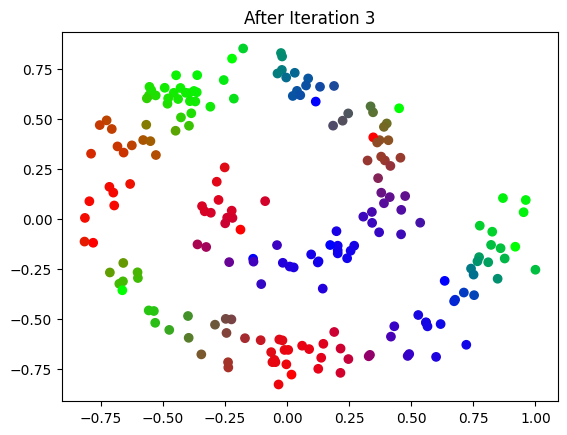

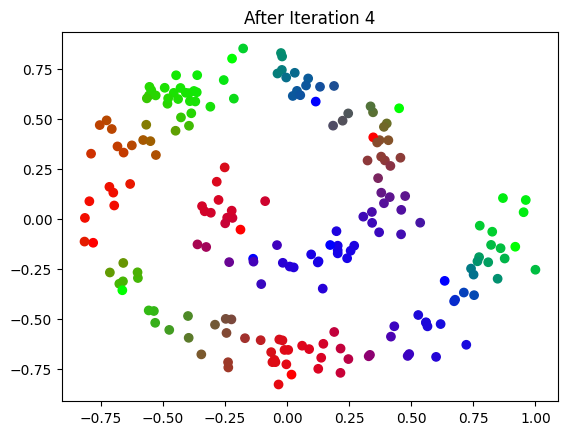

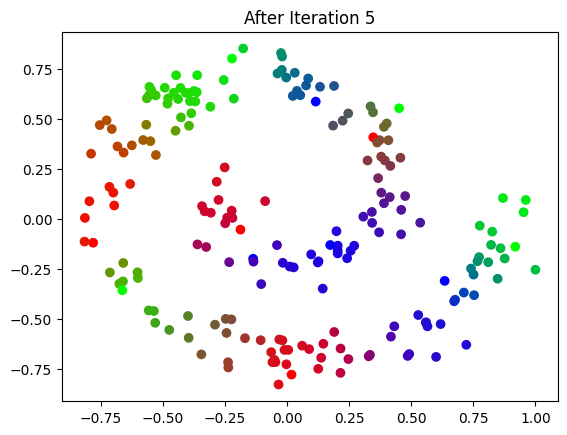

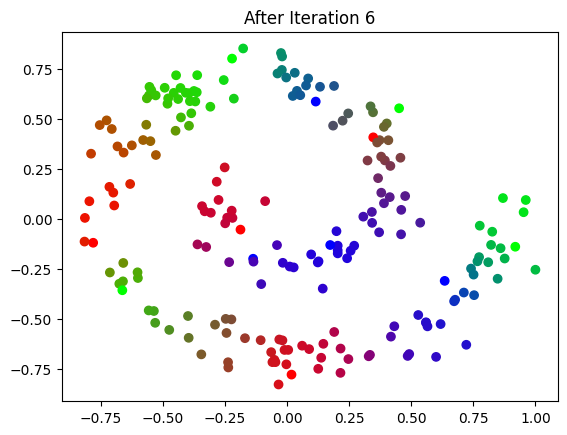

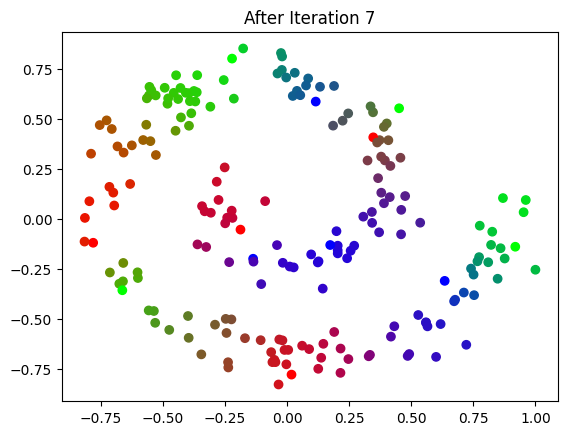

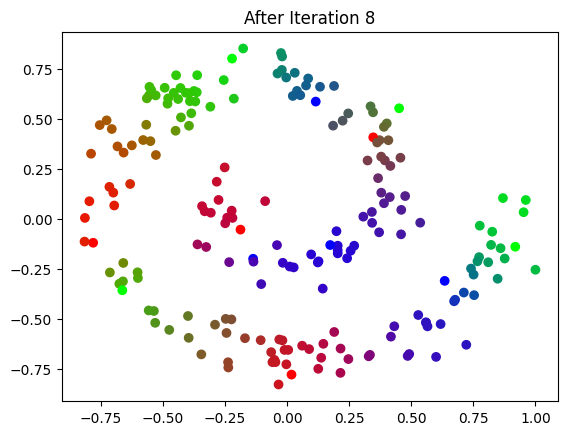

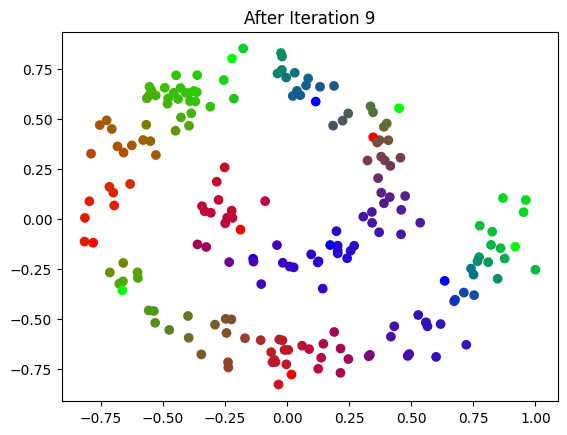

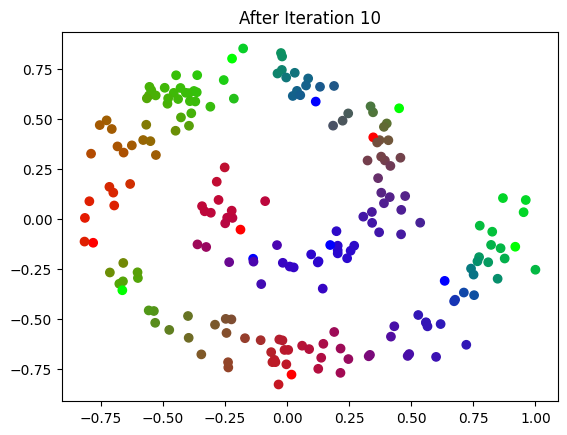

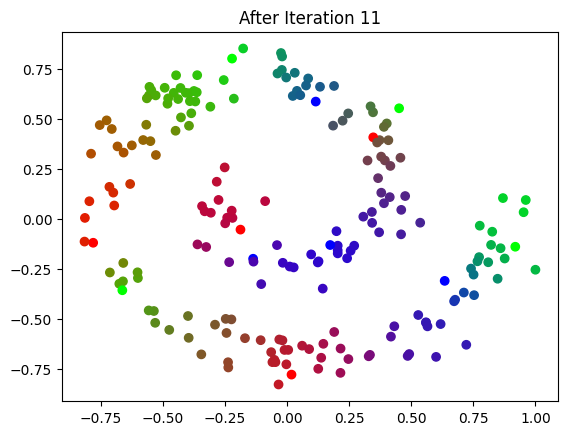

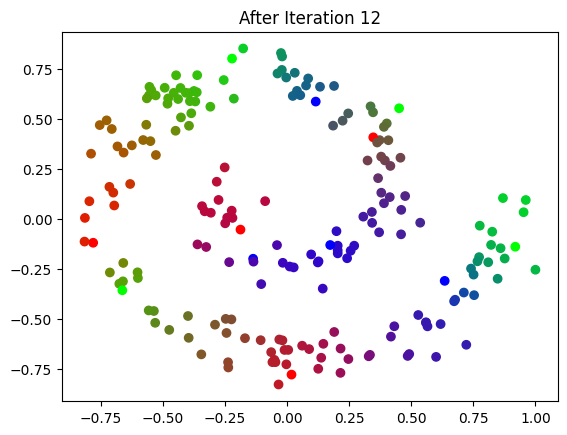

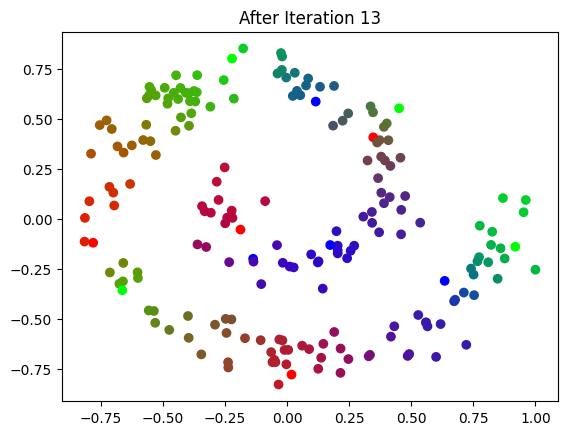

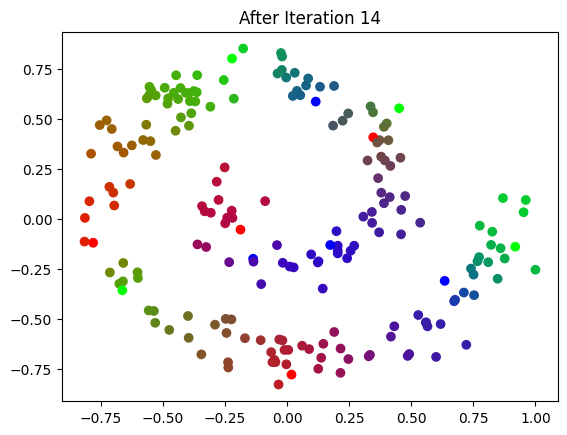

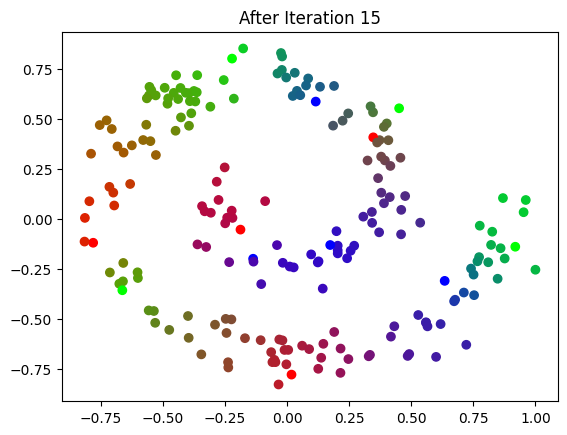

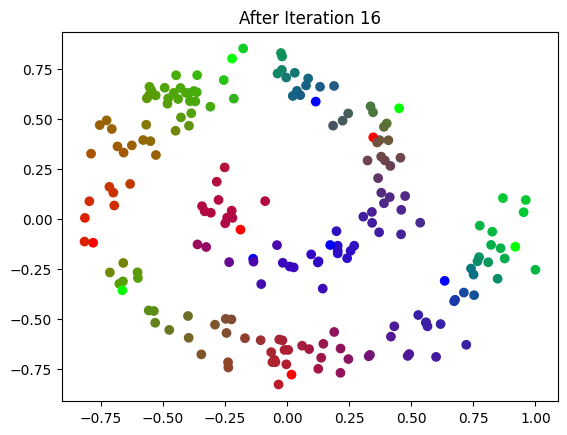

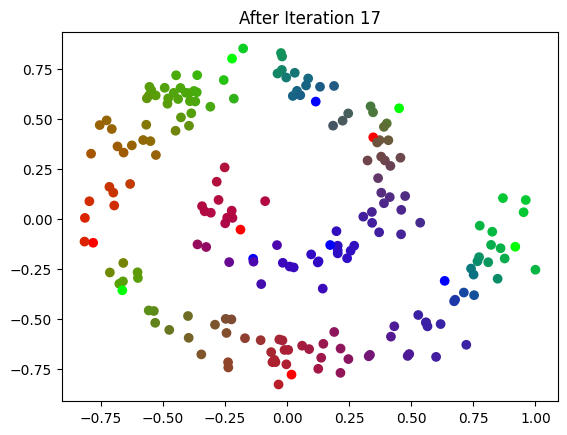

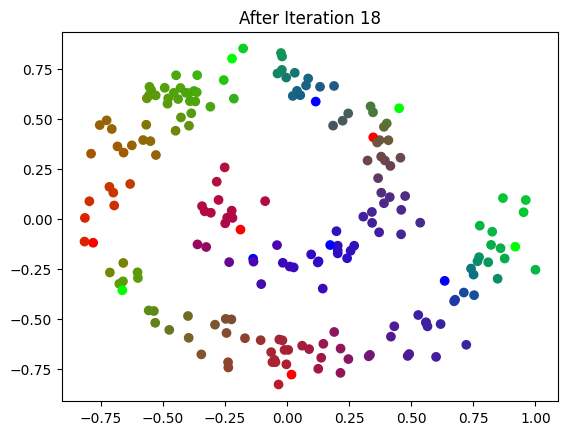

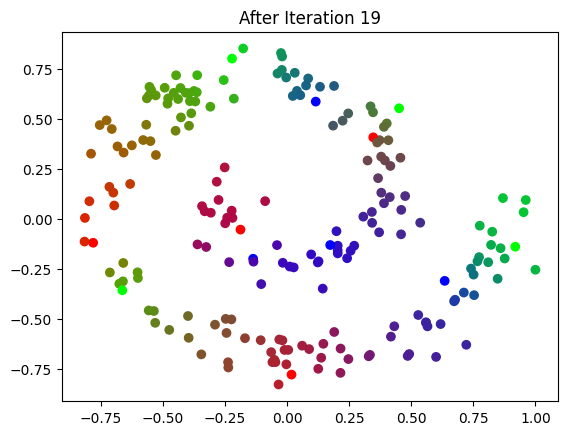

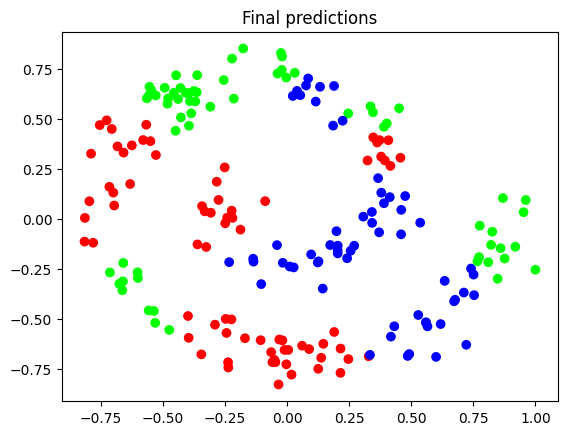

In [15]:
num_iters = 20
lp = LabelPropagation(num_iters)
predictions = lp(A, x, coords)
plot_predictions(predictions, coords)

We will add a stopping criterion to our algorithm, and stop training when the updates of all points $i$ satisfy $||x_i^{t+1} - x_i^t||_2 \leq \epsilon$.

#### Question 2.2: Implement the uniform variation criterion.
*Tips:* 
- You can use the function `scipy.linalg.norm`.
- Do not forget that unexpected behaviours can happen when arrays are modified in place. To avoid this, you can use `np.copy()`.

In [16]:
class UniformVariationCriterion():
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.last_values = None
        
    def step(self, x):
        """ Return True if the class probabilities for each point have changed by less than epsilon,
            False otherwise.
        """
        # Your solution here ###########################################################
        if self.last_values is None:  # First iteration
            self.last_values = x.copy()
            return False
        
        change = LA.norm(x - self.last_values, axis=1)
        print("Change", change.max())
        self.last_values = x.copy()
        return change.max() < self.threshold
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

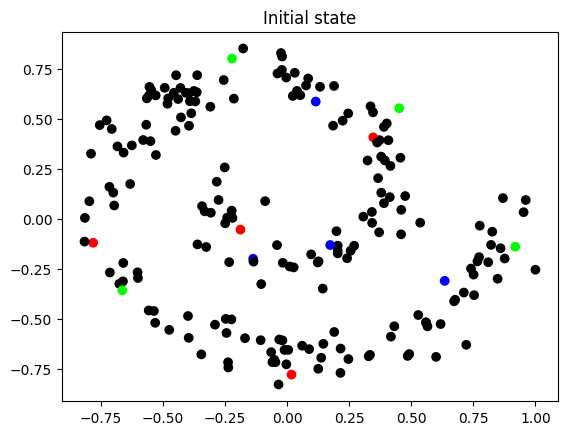

Change 0.8792430926876603
Change 0.20850253265715307
Change 0.09925996424269001
Change 0.07405023059648803
Change 0.05450538463011914
Change 0.04333188856364102
Change 0.03772562646036459
Change 0.03304228935714276
Change 0.028964649831480137
Change 0.0254234872264145
Change 0.022346823122019445
Change 0.01967046169940906
Change 0.017339391760295624
Change 0.015306410330124857
Change 0.013531415347302074
Change 0.01198289355284617
Change 0.010627837285079846
Change 0.009441026044059875
Stopping criterion triggered after 18 iterations.


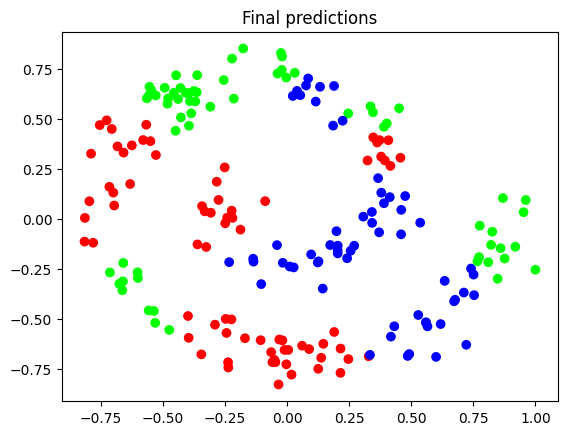

In [17]:
stopping_criterion = UniformVariationCriterion()
num_iters = 200

x = sample_signal(n)
lp = LabelPropagation(num_iters, stopping_criterion)
predictions = lp(A, x, coords, plot_each_iteration=False)
plot_predictions(predictions, coords)

An alternative way to perform semi-supervised learning is to apply a low-pass filter on the signal. Use the functions defined in the previous exercises to apply a Tikhonov filter with $\alpha=1$ to the signal `x`.

#### Question 2.3: Connection with low-pass filtering. Use the functions defined in the previous exercises to compute a Tikhonov filter. Apply this filter to the signal `x` to compute predictions for unseen nodes.


In [18]:
# Your solution here ###########################################################
A_dense = A.toarray()
L = compute_laplacian(A_dense, 'sym')
eigenvalues, eigenvectors = spectral_decomposition(L)
alpha = 1
tk_filter = 1 / (1 + alpha * eigenvalues)
tk_filter = tk_filter[:, None]
filtered = filter_signal(x, tk_filter, eigenvectors)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

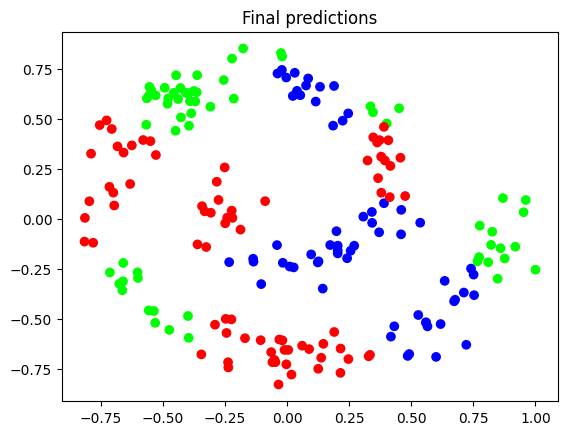

In [19]:
plot_predictions(filtered, coords)

#### Question 2.4: What do you observe? How do the results from label propagation and low-pass filtering compare?

**Your answer here:**

We observe that label propagation gives very similar results as the low-pass filter. This is expected as label propagation algorithm smoothly propagates the existing labels to the unlabeled nodes, thus avoiding quick transitions in the signal and promoting low frequency components, as a low-pass filter would do.

#### Question 2.5: In our implementation, we initialized the labels of the unlabeled nodes to an array of zeros. However, this initialization is arbitrary. Prove that the label propagation algorithm is insensitive to the initialization of the labels of the unlabeled nodes. 

**Your answer here:**

Please see the intermediate step of the proof in the original paper for label propagation, where it is proven that:

$$
\lim_{n \to \infty} \bar{T}^{n}_{uu} Y^0 = 0
$$